# __Projet Numerique 3: __Câble sous marin
---



In [16]:
from matplotlib import pyplot as plt
import numpy as np 
#from matplotlib.pyplot import *
#import seaborn as sns
#sns.set()
%matplotlib notebook
import random as r


In [17]:
#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées
unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

---
## Questions Théoriques:

**1)**
`La loi des grands nombres` pour  une suite de variables indépendantes de même loi nous autorise à approcher l'espérance par moyenne empirique des réalisations.

**2)**
D'après le cours ProbasIV, le vecteur **Y** $\in \mathbb{R} ^{N - n}$ des composantes de **Z** $\in \mathbb{R} ^{N}$ non connues correspondant aux points de discrétisation sans observation, connaissant les valeurs prises par les composantes aux sites d'observation (**z** $\in \mathbb{R} ^{n}$) est gaussien, de densité:

> $f_{Y|Z=z}(y) = \frac{1}{(2\pi)^{k/2}\sqrt{\det (\Sigma S_Y)}}\exp \left(-\frac{1}{2}\left(y - \psi(z)\right)^t \Sigma S_Y^{-1}\left(y - \psi(z))\right)\right)$

Où $\psi$ est l'espérance conditionnelle de **Y** sachant **Z**, et $S_{Y}$ le `complément de Schur` de la matrice de covariance de **Y**.
On a $ m_{Y|Z = z} = \psi(z) = m_{Y} + \Sigma_{Y,Z}\Sigma_{Z}^{-1}(z − m_{Z}) $ où $m_{Y}$ et $m_{Z}$ sont des vecteurs d'espérance ne contenant qu'une seule valeur $\mu$, et $\Sigma_{Y,Z}, \Sigma_{Z}$ connues en fonction des {$x_{j_1}, ..., x_{j_n}$} points d'observation.

**3)**
**Y** $= (Y_{1}, Y_{2}, ..., Y_{p})$ un vecteur de composantes gaussiennes centrées réduites et indépendantes.
Alors **Z** $= m + RY$ est un vecteur gaussien, d'ésperance m et de matrice de covariance $R R^{t}$ 

**4)**
Un algorithme de simulation conditionnelle envisageable serait le suivant:  
On commence par simuler un vecteur $Y_1$ de composantes gaussiennes centrées réduites indépendantes, que l'on utilise pour obtenir une simulation du vecteur **Y** $\in \mathbb{R} ^{N - n}$ des composantes de **Z** $\in \mathbb{R} ^{N}$ non connues correspondant aux points de discrétisation sans observation: **Y** $= m_{Y|Z = z} + L_{Y}Y_1 $ où $L_{Y} L_{Y}^{-1} = \Sigma_{Y|Z = z}$ (_`Decomposition de Cholesky`_)  
On calcule ensuite la longueur de câble correspondant à cette réalisation de **Z**  
On recommence pour obtenir $l_{(1)}, ..., l_{(K)}$

---
## Implementation:

In [18]:
##1 Covariance
def cov(h, a = 50, sigma_carre = 12 ):
    return (sigma_carre * np.exp(np.abs(h) / a))
    
##2 Matrice de Distance
Distance = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Distance[i][j] = np.abs( Delta * (i -j))
        
##3  Matrice de Covariance de Z
Covariance = cov(Distance)

##4 Matrice extraites:
n = len(observation_indexes)
p = len(unknown_indexes)

cov_obs = np.zeros((n,n))
for i, k in enumerate(observation_indexes): #C_Z
    for j, l in enumerate(observation_indexes):
        cov_obs[i][j] = Covariance[k][l]
        
cov_YZ = np.zeros((p,n))
for i,k in enumerate(unknown_indexes):
    for j,l in enumerate(observation_indexes):
        cov_YZ[i][j] = Covariance[k][l]

cov_unknown = np.zeros((p,p))   #= C_Y
for i, k in enumerate(unknown_indexes):
    for j, l in enumerate(unknown_indexes):
        cov_unknown[i][j] = Covariance[k][l]
        

### 5) Calcul de l'espérance conditionnelle:

L'espérance conditionnelle des composantes non observées **Y** connaissant les observations **Z** nous est donnée par la formule suivante:
> $ m_{Y|Z = z} = m_{Y} + \Sigma_{Y,Z}\Sigma_{Z}^{-1}(z − m_{Z}) $

<IPython.core.display.Javascript object>


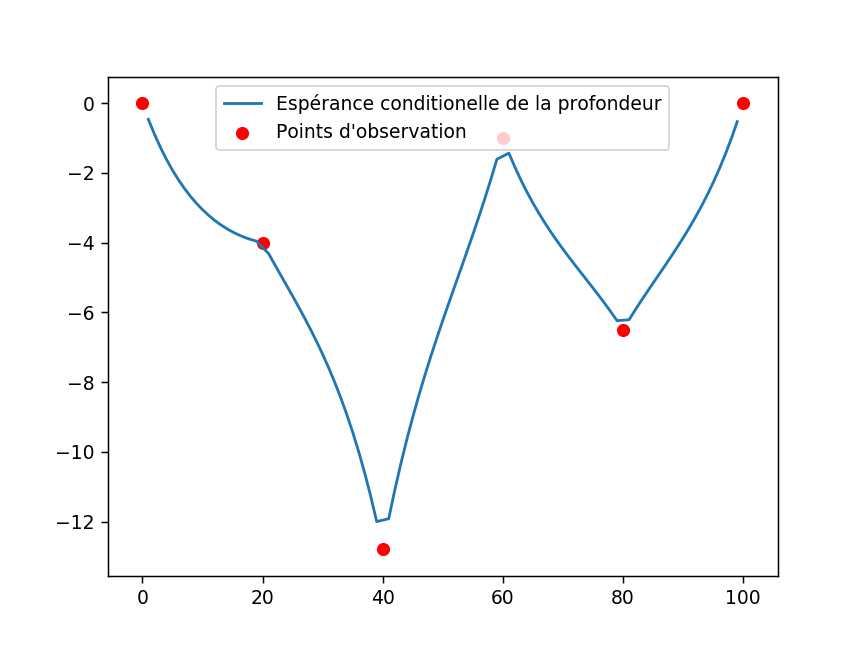

In [19]:
obs= np.array([depth])
E_YZ = mu * np.ones((p, 1)) + np.dot(np.dot(cov_YZ, np.linalg.inv(cov_obs)), (obs.T - mu * np.ones((n, 1))))

#Représentation
plt.plot(unknown_indexes, E_YZ.T[0], label = 'Espérance conditionelle de la profondeur')
plt.scatter(observation_indexes, depth, color = 'red', label = "Points d'observation")
plt.legend()
plt.show()

### 6) Calcul de la variance conditionnelle:

La variance conditionnelle des composantes non observées **Y** connaissant les observations **Z** nous est donnée par $S_{Y}$ le `complément de Schur` de la matrice de covariance de **Y**:
> $var_{Y|Z} = \Sigma S_Y = \Sigma_Y − \Sigma_{Y,Z}\Sigma_{Z}^{-1}\Sigma_{Z,Y}$

<IPython.core.display.Javascript object>


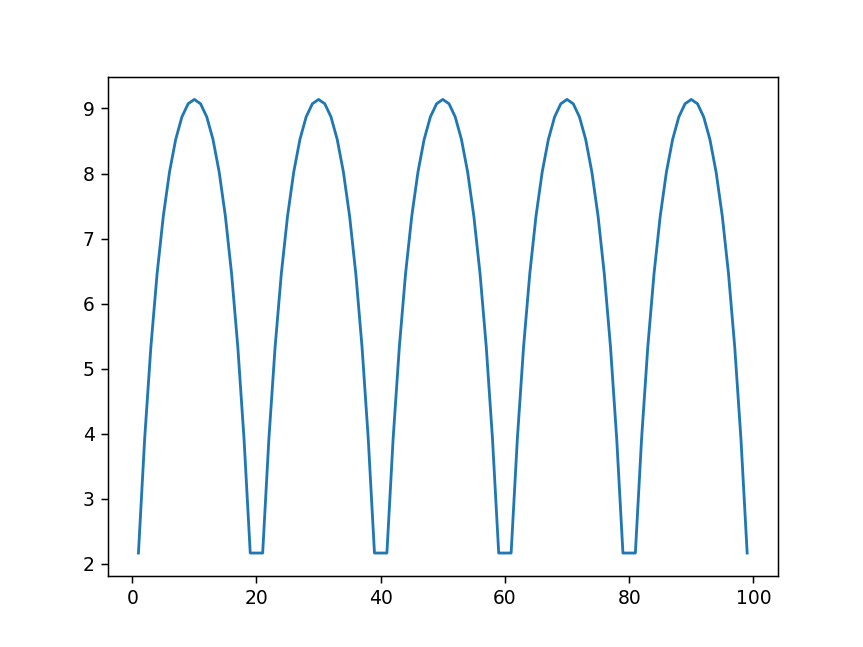

In [20]:
var_YZ = cov_unknown - np.dot(cov_YZ, np.dot(np.linalg.inv(cov_obs), cov_YZ.T))

#La pratique nous montre que pour que ça marche on doit prendre l'opposé de la valeur donnée par la formule du cours??
var_YZ = -var_YZ

#Et on plot
plt.figure()
plt.plot(unknown_indexes, [var_YZ[i][i] for i in range(p)], label = 'Espérance conditionelle de la profondeur')
plt.show()

La variance des valeurs simulées est une fonction croissante de la distance aux points d'observation.

### 7) Simulation conditionnelle

In [26]:
def liste_profondeur(Y, prof = depth, i_obs = observation_indexes):
    #prend un vecteur simulé en parametre, et depth et observations_indexes
    #renvoie la liste de toutes les profondeurs, en insérant celles des sites d'observation
    y = list(Y.T[0])
    z = list(prof)[::-1]
    for i in i_obs:
        a = z.pop()
        y = y[:i] + [a] + y[i::]
    return y

<IPython.core.display.Javascript object>


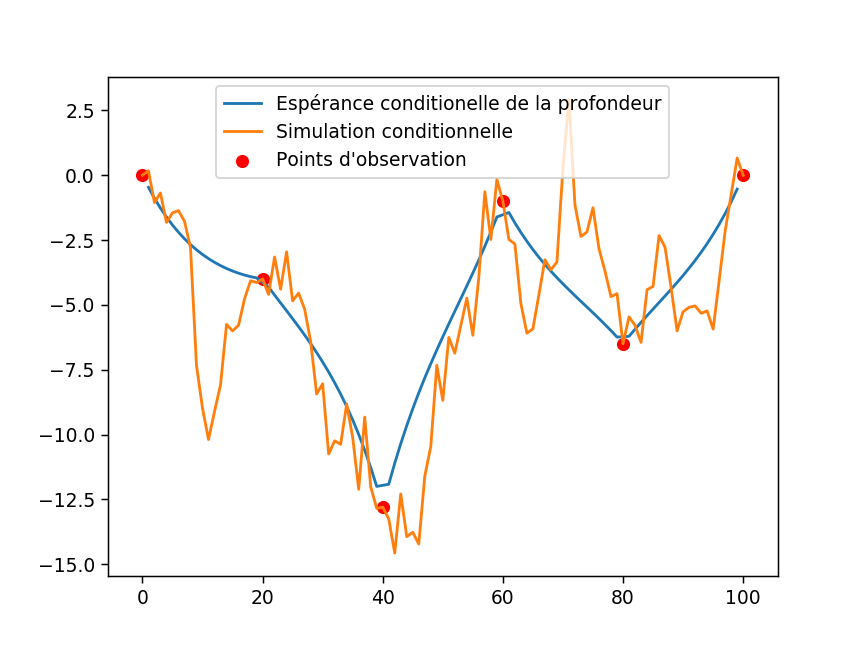

In [27]:
#On commence par définir une fonction générant des valeurs selon une loi normale centrée réduite.
def loi_normale():
    u = 0
    v = 0
    while u == 0 or v == 0:
        u = r.random()
        v = r.random()
    return np.sqrt(-2*np.log(u)) * np.cos(2*np.pi * v)


def Cholesky(A):
    #A symetrique definie positive
    #Calcul de la factorisation de Cholesky de A
    L = np.zeros(A.shape)
    L[0][0] = np.sqrt(A[0][0])
    for i in range(1, len(L)):
        j = 0
        s = 0
        while j < i:
            sum = 0
            for k in range(j):
                sum += L[i][k] * L[j][k]   
            L[i][j] = (A[j][i] - sum) / L[j][j]
            s += (L[i][j]) ** 2
            j += 1
        L[i][i] = np.sqrt(A[i][i] - s)
    return L
    
L = Cholesky(var_YZ)

def simulation():
    #On génère un vecteur gaussien d'esperance 0 de matrice de covariance la matrice identité
    Gaussien = np.array([[loi_normale() for i in range(p)]])
    Gaussien = Gaussien.T
    
    #On obtient un vecteur Y des profondeurs aux points non mesurés par la méthode décrite plus haut
    Y = E_YZ + np.dot(L, Gaussien)
    return Y

Y = simulation()

#On affiche le résultat
plt.figure()
plt.plot(unknown_indexes, E_YZ.T[0], label = 'Espérance conditionelle de la profondeur')
plt.plot(discretization_indexes, liste_profondeur(Y), label = 'Simulation conditionnelle')
plt.scatter(observation_indexes, depth, color = 'red', label = "Points d'observation")
plt.legend()
plt.show()

On constate que les valeurs de la simulation fluctuent autour de l'espérance.

### 8) Longueur du câble
On définit une fonction qui renvoie la longueur du câble pour une simulation donnée, en fonction du pas de discrétisation

In [28]:
def longueur(Z):
    l = 0
    for i in range(1, len(Z)):
        l += np.sqrt(Delta ** 2 + (Z[i] - Z[i-1]) **2 )
    return l


### 9) Estimation de la longueur
On calcule la longueur du câble à partir de 100 simulations

In [32]:
def moyenne_longueur(nb = 100):
    #renvoie la longueur moyenne et la table des longueurs correspondants aux différentes simulations
    s = 0
    lo = []
    for i in range(nb):
        Y = simulation()
        Z = liste_profondeur(Y, depth, observation_indexes)
        l = longueur(Z)
        lo.append(l)
        s += l
    #     plt.plot(discretization, Z)
    # plt.plot(discretization, liste_profondeur(E_YZ, depth, observation_indexes), color = 'red')
    # plt.plot(discretization, np.array(liste_profondeur(np.array([[var_YZ[i][i] for i in range(p)]]).reshape((p,1)), [0 for i in depth], observation_indexes)) + np.array(liste_profondeur(E_YZ, depth, observation_indexes)), color = 'red')
    # plt.plot(discretization, - np.array(liste_profondeur(np.array([[var_YZ[i][i] for i in range(p)]]).reshape((p,1)), [0 for i in depth], observation_indexes)) + np.array(liste_profondeur(E_YZ, depth, observation_indexes)), color = 'red')
    # plt.show()
        
    s = s / nb
    return s, lo

esperance_longueur, l = moyenne_longueur(100)
#Longueur de l'espérance conditionnelle   
longueur_esperance = longueur(liste_profondeur(E_YZ, depth, observation_indexes))

print(f"La valeur moyenne de la longueur est: {esperance_longueur}, tandis que la longueur de l'espérance conditionnelle vaut {longueur_esperance}")
print(f"Soit une difference de {esperance_longueur - longueur_esperance}, c'est à dire une différence d'environ {100 * (esperance_longueur - longueur_esperance) / esperance_longueur } %" )

La valeur moyenne de la longueur est: 522.5320035858338, tandis que la longueur de l'espérance conditionnelle vaut 501.646841691841
Soit une difference de 20.885161893992745, c'est à dire une différence d'environ 3.9969153565083104 %


### 10) Representation de la suite des moyennes des longueurs
Representation de la suite des moyennes des longueurs en fonction du nombre de simulation.  
On constate que la suite converge vers une valeurs moyenne, l'espérance de la longueur

<IPython.core.display.Javascript object>


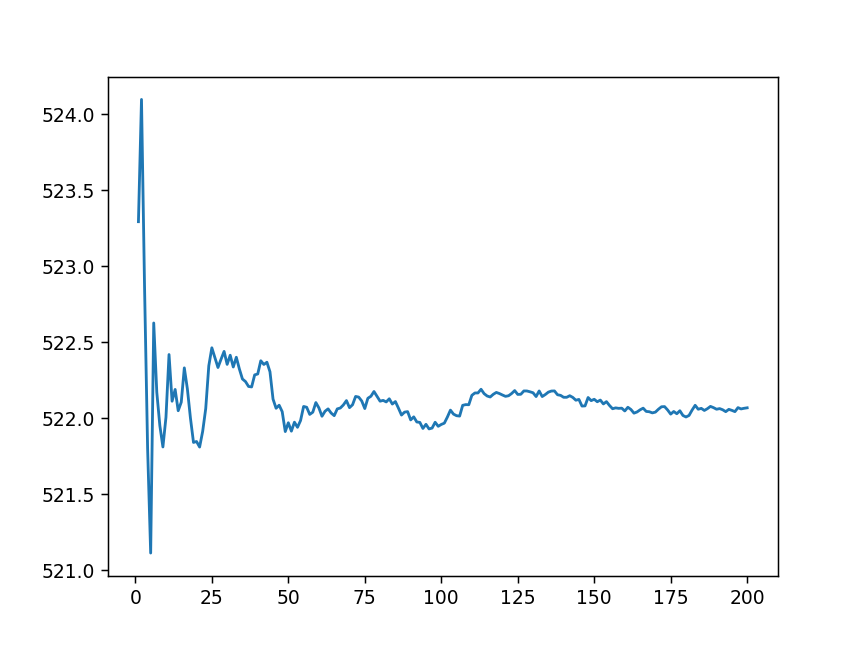

In [37]:
s, l = moyenne_longueur(200)
Mn = []
for i in range(1, len(l) + 1):
    Mn.append(sum(l[:i])/(i))

plt.figure()
plt.plot([i for i in range(1, len(Mn)+1)], Mn)
plt.show()

### 11) Histogramme des longueurs de câble simulées

<IPython.core.display.Javascript object>


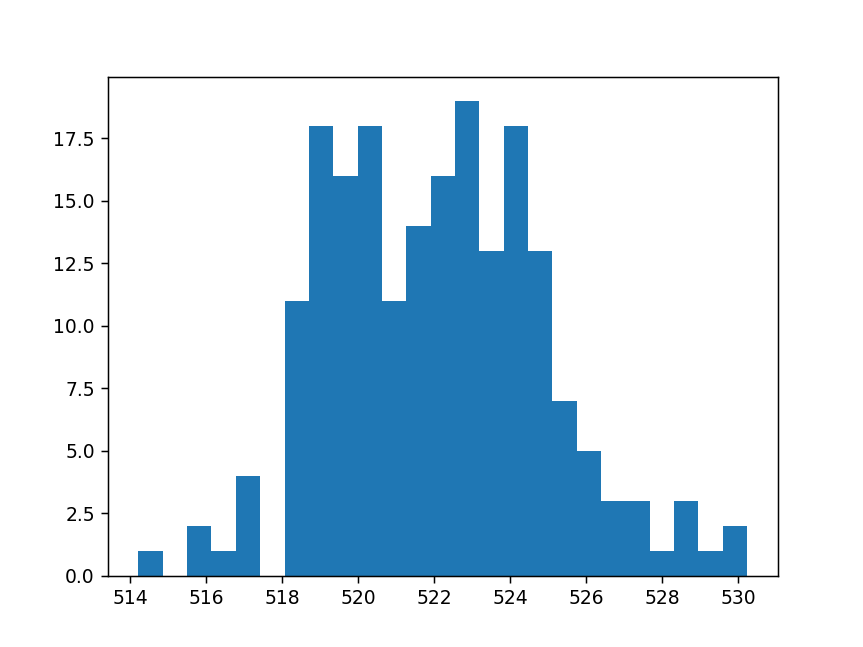

In [56]:
n_bins = 25

plt.figure()
plt.hist(l, bins=n_bins)
plt.show()


Aurait-on une distribution s'approchant d'une distribution gaussienne?

### 12) Intervalle de confiance

__Première Méthode: __   
On trie notre liste des longueurs et on calcule l'écart à la moyenne. On supprime les longueurs présentant le plus grand écart jusqu'à ne plus avoir que 95% des valeurs initiales.

__Deuxième Méthode:__    
On calcule l'écart type de notre échantillon. Puis on estime l'intervalle de confiance à 95% selon la formule:
> $I_{95} = [ m - 1,96 \times \frac{\sigma}{\sqrt{taille de l'échantillon}}; m + 1,96 \times \frac{\sigma}{\sqrt{taille de l'échantillon}} ]$ , où m est la moyenne des valeurs de l'échantillon

In [52]:
#Première Méthode:
d = sorted(l)
conserver = int(0.95 * len(l))
ecarts = [(i, abs(longueur - s)) for i, longueur in enumerate(d)]
ecarts = sorted(ecarts, key = lambda x: x[1])
a_supprimer = []
j = len(d)
while j > conserver:
    i, ecart = ecarts.pop()
    a_supprimer.append(i)
    j -= 1

a_supprimer.sort(reverse = True)
for i in a_supprimer:
    d.remove(d[i])
    
print(f"Méthode 1: Intervalle = [{d[0]}; {d[-1]}]")

#Deuxième Méthode:
ecart_type = np.sqrt(sum([(longueur - s)**2 for longueur in l])/len(l))

a1 = s - 1.96 * ecart_type / np.sqrt(len(l))
a2 = s + 1.96 * ecart_type / np.sqrt(len(l))

print(f"Méthode 2: Intervalle = [{a1}; {a2}]")

Méthode 1: Intervalle = [516.5037898685689; 527.2235278388663]
Méthode 2: Intervalle = [521.6723125650631; 522.4659983957818]


Les deux intervalles diffèrent beaucoup. Nous verrons comment ceci évolue pour un plus grand nombre de simulations.

### 13) Probabilité que la longueur soir supérieure à 525m
On estime cette probabilité comme étant $\frac{nombre_{longueur > 525}}{nombre_{simulations}}$

In [53]:
print(f"Proba(L > 525m) = {len([x for x in l if x>525])/len(l)}")

Proba(L > 525m) = 0.13


### 14) On augmente le nombre de simulations
On va définir une fonction qui réalise toutes les opérations précédentes

In [60]:
def analyse(nb_simulation):
    #Moyenne des longueurs
    esperance_longueur, l = moyenne_longueur(nb_simulation)
    #Longueur de l'espérance conditionnelle   
    longueur_esperance = longueur(liste_profondeur(E_YZ, depth, observation_indexes))
    print('---------------------')
    print(f"La valeur moyenne de la longueur est: {esperance_longueur}, tandis que la longueur de l'espérance conditionnelle vaut {longueur_esperance}")
    print(f"Soit une difference de {esperance_longueur - longueur_esperance}, c'est à dire une différence d'environ {100 * (esperance_longueur - longueur_esperance) / esperance_longueur } % \n" )
    
    #Suite des moyennes
    plt.figure()
    Mn = []
    for i in range(1, len(l) + 1):
        Mn.append(sum(l[:i])/(i)) 
    
    plt.subplot(2, 1, 1)
    plt.plot([i for i in range(1, len(Mn)+1)], Mn)
    plt.title('Moyenne des longueurs')
    plt.xlabel('Nombre de simulations')
    plt.ylabel('Mètres')
    
    #Histogramme
    n_bins = 25

    plt.subplot(2, 1, 2)
    plt.hist(l, bins=n_bins)
    plt.xlabel('longueur (mètres)')
    plt.ylabel('Nombre de réalisations')
    
    #Intervalle de confiance
    
    print('---------------------')
    
    d = sorted(l)
    conserver = int(0.95 * len(l))
    ecarts = [(i, abs(longueur - esperance_longueur)) for i, longueur in enumerate(d)]
    ecarts = sorted(ecarts, key = lambda x: x[1])
    a_supprimer = []
    j = len(d)
    while j > conserver:
        i, ecart = ecarts.pop()
        a_supprimer.append(i)
        j -= 1
    a_supprimer.sort(reverse = True)
    for i in a_supprimer:
        d.remove(d[i])
    print(f"Méthode 1: Intervalle = [{d[0]}; {d[-1]}]")

    ecart_type = np.sqrt(sum([(longueur - esperance_longueur)**2 for longueur in l])/len(l))
    a1 = s - 1.96 * ecart_type / np.sqrt(len(l))
    a2 = s + 1.96 * ecart_type / np.sqrt(len(l))
    print(f"Méthode 2: Intervalle = [{a1}; {a2}] \n")
    
    #Proba L > 525m
    print('---------------------')
    print(f"Proba(L > 525m) = {len([x for x in l if x>525])/len(l)}")
    
    plt.show()

---------------------
La valeur moyenne de la longueur est: 522.7600536489339, tandis que la longueur de l'espérance conditionnelle vaut 501.646841691841
Soit une difference de 21.113211957092858, c'est à dire une différence d'environ 4.0387959657054635 % 



<IPython.core.display.Javascript object>


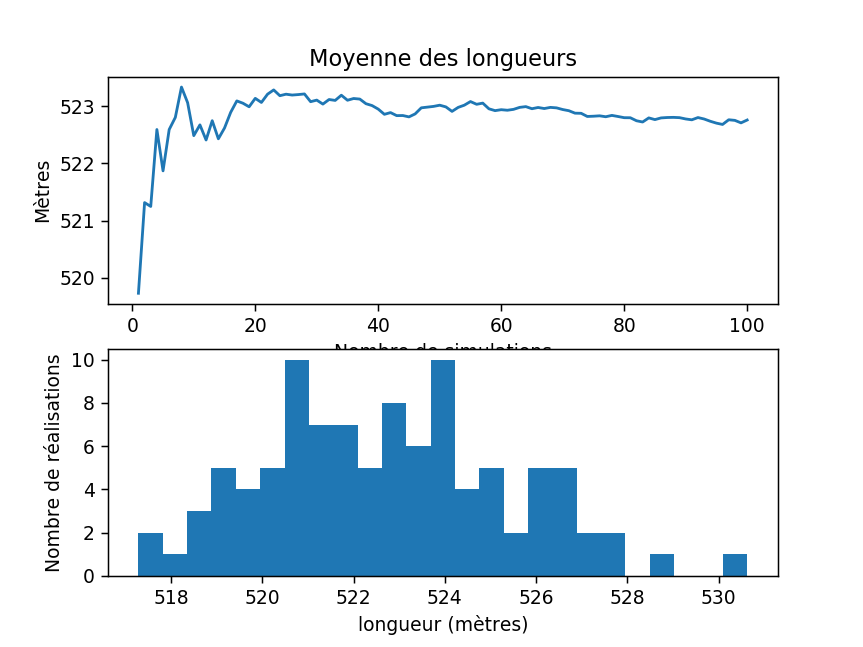

---------------------
Méthode 1: Intervalle = [518.3146328918838; 527.6686207153789]
Méthode 2: Intervalle = [521.5421470035071; 522.5961639573377] 

---------------------
Proba(L > 525m) = 0.22


In [62]:
analyse(100)

---------------------
La valeur moyenne de la longueur est: 522.3395781872547, tandis que la longueur de l'espérance conditionnelle vaut 501.646841691841
Soit une difference de 20.69273649541367, c'est à dire une différence d'environ 3.961548647572611 % 



<IPython.core.display.Javascript object>


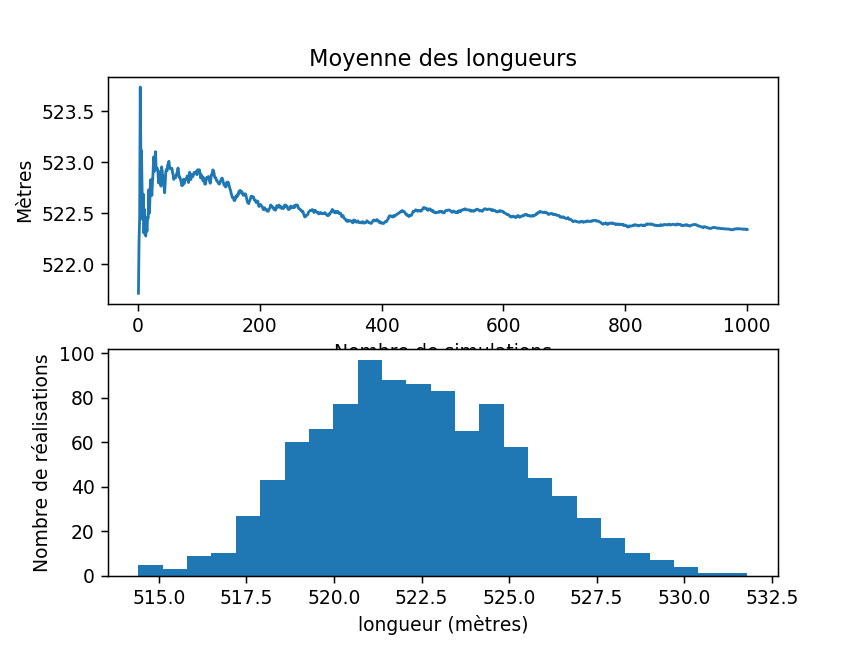

---------------------
Méthode 1: Intervalle = [516.8454950345248; 527.8530884726623]
Méthode 2: Intervalle = [521.8874444774151; 522.2508664834297] 

---------------------
Proba(L > 525m) = 0.189


In [63]:
analyse(1000)

---------------------
La valeur moyenne de la longueur est: 522.4577922351652, tandis que la longueur de l'espérance conditionnelle vaut 501.646841691841
Soit une difference de 20.810950543324225, c'est à dire une différence d'environ 3.983278812684822 % 



<IPython.core.display.Javascript object>


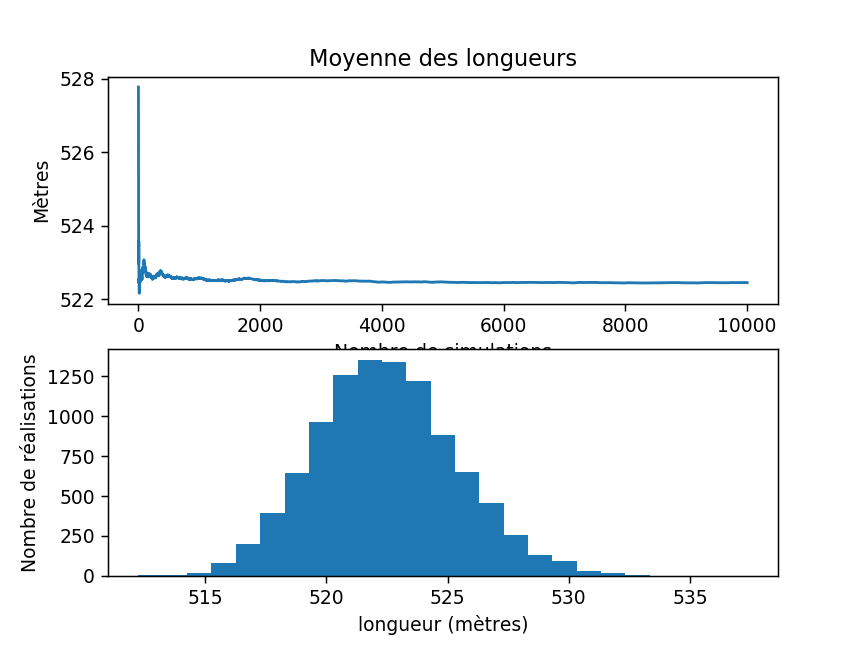

---------------------
Méthode 1: Intervalle = [516.8084008896094; 528.1065294945347]
Méthode 2: Intervalle = [522.0122429452987; 522.1260680155461] 

---------------------
Proba(L > 525m) = 0.1858


In [64]:
analyse(10000)

---------------------
La valeur moyenne de la longueur est: 522.4496509173059, tandis que la longueur de l'espérance conditionnelle vaut 501.646841691841
Soit une difference de 20.802809225464898, c'est à dire une différence d'environ 3.9817825868846444 % 



<IPython.core.display.Javascript object>


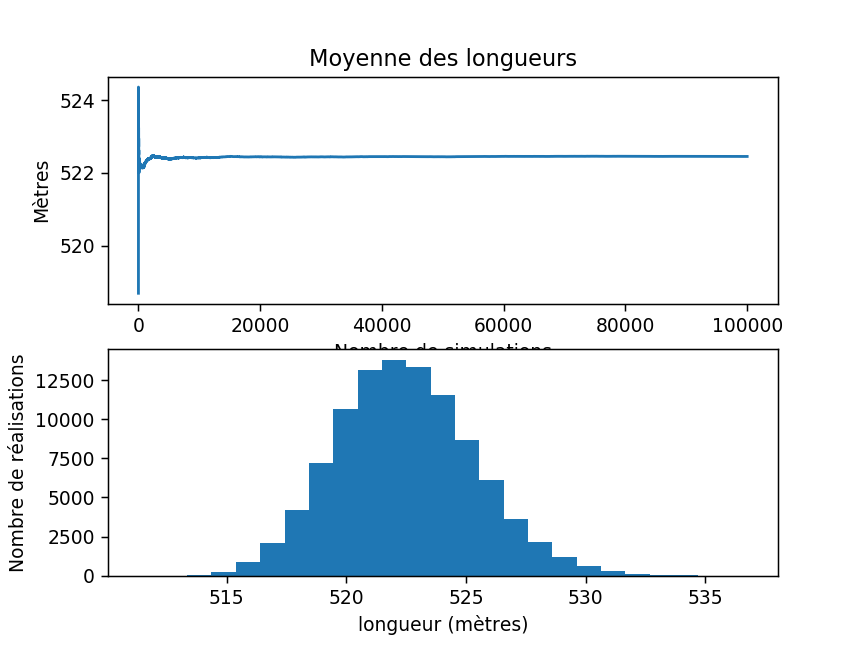

---------------------
Méthode 1: Intervalle = [516.8073998513366; 528.0916322877493]
Méthode 2: Intervalle = [522.0512903321087; 522.0870206287361] 

---------------------
Proba(L > 525m) = 0.18589


In [65]:
analyse(100000)

La distribution des longueurs semble effectivement s'effectuer selon une loi Normale